In [171]:
# Make sure you are running under a virtual environment
! pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings


In [2]:
import os 
import gdown

if not os.path.exists('data'):
    os.makedirs('data')
    gdown.download("https://drive.google.com/file/d/1pX6eLIK1kYzqSpbx-uTL6GuywHPhd1TE/view?usp=drive_link",
                   "data/tweets.zip", fuzzy=True)
    ! cd data && unzip tweets.zip

TWEETS_CSV = 'data/tweets.csv'

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium


## Task 1

At first we attempted to use Twitter API, but the free access was too limited and therfore blocked us from fetching tweets using the API:

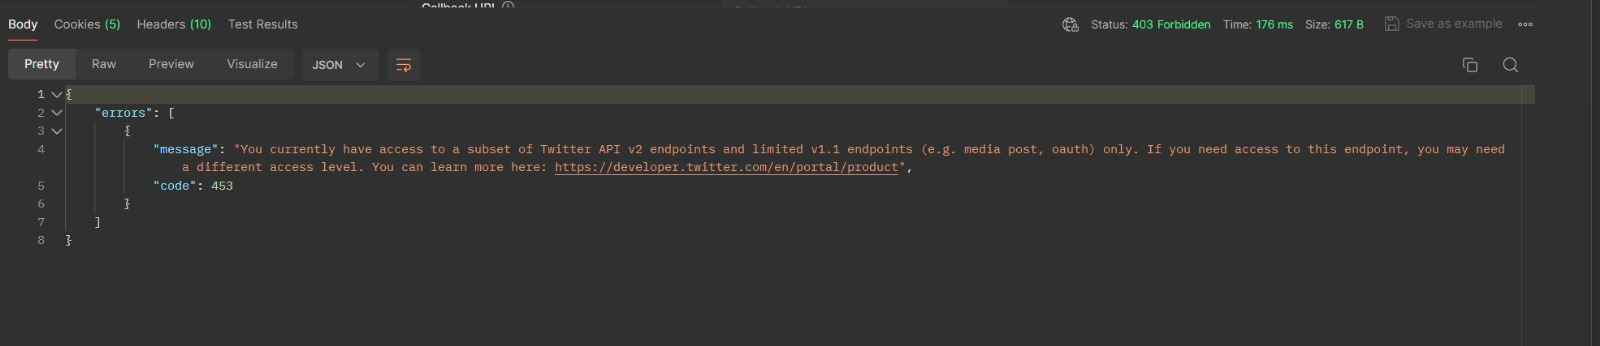

As an alternative, we opted to use the suggested Kaggle dataset.

The dataset source can be found here:
https://www.kaggle.com/datasets/mmmarchetti/tweets-dataset


In [4]:
tweets=pd.read_csv(TWEETS_CSV)
tweets.head()

,author,content,country,date_time,id,language,latitude,longitude,number_of_likes,number_of_shares
0,katyperry,Is history repeating itself...?#DONTNORMALIZEH...,NaN,12/01/2017 19:52,8.196330e+17,en,NaN,NaN,7900,3472
1,katyperry,@barackobama Thank you for your incredible gra...,NaN,11/01/2017 08:38,8.191010e+17,en,NaN,NaN,3689,1380
2,katyperry,Life goals. https://t.co/XIn1qKMKQl,NaN,11/01/2017 02:52,8.190140e+17,en,NaN,NaN,10341,2387
3,katyperry,Me right now 🙏🏻 https://t.co/gW55C1wrwd,NaN,11/01/2017 02:44,8.190120e+17,en,NaN,NaN,10774,2458
4,katyperry,SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...,NaN,10/01/2017 05:22,8.186890e+17,en,NaN,NaN,17620,4655


## Task 2 - Kubernetes Cluster Configuration

## Task 3 - Data Ingestion and Processing

In order to allow for insightful analysis in an efficient manner, we decided to create a pre-structured dataset that corresponds to the insights that we plan to offer.


### Hashtags

- **Table Name**: `hashtag_stats`
- **Primary Key**:, 
  - **Partition Key**: `tag_name`
  - **Clustering Key**: `date_time`
- **Columns**:
  - `date_time` (timestamp)
  - `tag_name` (text)
  - `number_of_likes` (int)
  - `number_of_shares` (int)
  - `country` (text)
  - `latitude` (float)
  - `longitude` (float)

### Author Popularity

- **Table Name**: `authors_stats`
- **Primary Key**:, 
  - **Partition Key**: `author_name`
  - **Clustering Key**: `date_time`
- **Columns**:
  - `date_time` (timestamp)
  - `author_name` (text)
  - `number_of_likes` (int)
  - `number_of_shares` (int)
  - `country` (text)
  - `latitude` (float)
  - `longitude` (float)


### Emoji Stats

- **Table Name**: `emoji_stats`
- **Primary Key**:, 
  - **Partition Key**: `emoji, author`
  - **Clustering Key**: `date_time`
- **Columns**:
  - `date_time` (timestamp)
  - `emoji` (text)
  - `author` (text)
  - `number_of_likes` (int)
  - `number_of_shares` (int)
  - `country` (text)
  - `latitude` (float)
  - `longitude` (float)

In [5]:
# Kill any running previous instance
! docker kill my_cassandra || echo true

# Setting up cassandra instance using docker with local persistent storage under the persistent_data folder.
# The cassandra.yaml file is also mounted to the container to allow for configuration changes.
! docker run --rm -d --name my_cassandra -p 9042:9042 -v `pwd`/cassandra.yaml:/etc/cassandra/cassandra.yaml -v `pwd`/persistent_data:/var/lib/cassandra cassandra 

my_cassandra
3f35f7e8362995961c4e92187b510a1efa0e2fe081a509e66df760b2ea62bff5


In [8]:
from cassandra.cluster import Cluster
from cassandra.query import BatchStatement
from cassandra.query import SimpleStatement

# Setup Cassandra Connection
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()

In [9]:
# Create Keyspace and Tables

if 'BatchStatement' in locals():
    session.execute("DROP KEYSPACE IF EXISTS twitter_insights")

if 'Cluster' in locals():
    session.execute("""
        CREATE KEYSPACE IF NOT EXISTS twitter_insights WITH replication = {
            'class': 'SimpleStrategy', 'replication_factor': '3'
        }
    """)

    session.set_keyspace('twitter_insights')

    session.execute("""
        CREATE TABLE IF NOT EXISTS hashtag_stats (
            date_time timestamp,
            year int,
            tag_name text,
            number_of_likes int,
            number_of_shares int,
            country text,
            latitude float,
            longitude float,
            PRIMARY KEY (tag_name, year, date_time)
        );
    """)

    session.execute("""
        CREATE TABLE IF NOT EXISTS author_stats (
            date_time timestamp,
            author_name text,
            number_of_likes int,
            number_of_shares int,
            country text,
            latitude float,
            longitude float,
            PRIMARY KEY (author_name, date_time)
        );
    """)

    session.execute("""
        CREATE TABLE IF NOT EXISTS emoji_stats (
            date_time timestamp,
            emoji text,
            author text,
            number_of_likes int,
            number_of_shares int,
            country text,
            latitude float,
            longitude float,
            PRIMARY KEY ((emoji, author), date_time)
        );
    """)


In [10]:
# Setting the batch size so that we can control the number of rows inserted per batch
batch_size = 1024*25 # 25KB

In [11]:
import re

# Create individual insert statements
insert_authors_popularity = session.prepare(
    f"INSERT INTO author_stats (date_time, author_name, number_of_likes, number_of_shares) "
    f"VALUES (?, ?, ?, ?)"
)
insert_hashtag_stats = session.prepare(
    f"INSERT INTO hashtag_stats (date_time, year, tag_name, number_of_likes, number_of_shares) "
    f"VALUES (?, ?, ?, ?, ?)"
)
insert_emoji_stats = session.prepare(
    f"INSERT INTO emoji_stats (date_time, emoji, author, number_of_likes, number_of_shares) "
    f"VALUES (?, ?, ?, ?, ?)"
)

def extract_hashtags(tweet):
    # Define the regex pattern for hashtags
    hashtag_pattern = r'#\w+'

    # Find all hashtags in the tweet
    hashtags = re.findall(hashtag_pattern, tweet)

    return hashtags

def extract_emojis(tweet):
    # Define the regex pattern for emojis
    emoji_pattern = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF]'

    # Find all emojis in the tweet
    emojis = re.findall(emoji_pattern, tweet, flags=re.UNICODE)

    return emojis

# Ingestion of tweets
batch = BatchStatement()
for index, row in tweets.iterrows():
    # Extract data from the CSV row
    date_time = pd.to_datetime(row['date_time'])
    author_name = row['author']
    number_of_likes = int(row['number_of_likes'])
    number_of_shares = int(row['number_of_shares'])
    content = row['content']
    # Note: Current dataset includes empty geo fields, ignoring them for this calculation.
    # country = row['country']
    # latitude = float(row['latitude'])
    # longitude = float(row['longitude'])

    # Insert data into author_stats table
    batch.add(
        insert_authors_popularity,
        (date_time, author_name, number_of_likes, number_of_shares)
    )

    # Insert data into hashtag_stats table
    hashtags = extract_hashtags(content)
    for hashtag in hashtags:
        batch.add(
            insert_hashtag_stats,
            (date_time, date_time.year, hashtag, number_of_likes, number_of_shares)
        )

    # Insert data into emoji_stats table
    emojis = extract_emojis(content)
    for emoji in emojis:
        batch.add(
            insert_emoji_stats,
            (date_time, emoji, author_name, number_of_likes, number_of_shares)
        )

    if index % batch_size == 0:
        session.execute(batch)
        batch.clear()

session.execute(batch)


/tmp/ipykernel_34091/2488258634.py:39: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  date_time = pd.to_datetime(row['date_time'])


# Task 4 - Data Analysis and Insight Extraction + Task 5 -	Insight visualizations

Execute these two commands, in order to start a cqlsh session within our cassandra container, which allows us to run CQL commands directly against your Cassandra database.

Starting a `cqlsh` session on the instance:
`docker exec -it my_cassandra cqlsh`

Applying the keyspace:
`use twitter_insights`

-- Query1: Most Popular Hashtags by Year
-- To find the most popular hashtags by year, we can extract the data from the DB and then use pandas to aggregate the number of likes for each hashtag, grouped by year, and sort them in descending order by likes.

```SQL
SELECT tag_name, number_of_likes, number_of_shares
FROM hashtag_stats
```

-- Query2: Most Popular Author by Year
-- Similar to hashtags, we we can extract the data from the DB and then use pandas to aggregate the number of likes and shares for each author, filtering by year, to find the most popular author by likes, show how many shares he got.

```SQL
SELECT author_name, date_time, number_of_likes, number_of_shares
FROM author_stats
```

-- Query3: Correlation between Hashtag and Likes/Shares
-- This query extracts the number of likes and shares for a specific hashtag, we will then calculate the correlation between them in .

```SQL
SELECT tag_name, number_of_likes, number_of_shares
FROM hashtag_stats
WHERE tag_name = 'your_hashtag'
```

-- Query4: Correlation between Likes and Shares Globally
-- To understand the relationship between likes and shares across all hashtags, we calculate the correlation of all the likes and shares globally.

```SQL
SELECT number_of_likes, number_of_shares
FROM hashtag_stats;
```


-- Query5: Emoji Histogram
-- To understand emoji usage, this query get all the emojis, we then will use pandas to sort and sum them in order to create a histogram of most used emojis.

```SQL
SELECT emoji
FROM emoji_stats
```

-- Query6: Most Used Emojis For a Given Author
-- For a specific author, this query finds the number of usages of emojis by aggregating likes and shares, providing insights into the author's emoji preferences, we then use pandas to get the top ten used Emojis.

```SQL
SELECT emoji, author, SUM(number_of_likes) + SUM(number_of_shares) AS total_interactions
FROM emoji_stats
WHERE author = 'your_author'
GROUP BY emoji, author
ALLOW FILTERING;
```

-- Query7: Daily Active Users
-- To find the number of unique active users per day, which can help understand daily user engagement and activity levels.
The query will fetch all relevant data, we will use pandas to show the distribution of days based on the number of unique users observed each day

```SQL
SELECT author_name, date_time, COUNT(*) AS count
FROM author_stats
GROUP BY author_name, date_time
ORDER BY date_time ASC;
```

-- Query8: Hashtag Trend Over Time
-- To analyze the popularity of a specific hashtag over time, this query tracks the sum of likes and shares for a hashtag across different months or years, providing insight into its trending status.

```SQL
SELECT year, month, tag_name, SUM(number_of_likes) AS total_likes, SUM(number_of_shares) AS total_shares
FROM hashtag_stats
WHERE tag_name = 'specific_hashtag'
GROUP BY year, month, tag_name
ORDER BY year ASC, month ASC;
```

-- Query9: Top Countries by User Engagement
-- To identify which countries have the highest user engagement, by aggregating likes and shares for tweets originating from different countries.

```SQL
SELECT country, SUM(number_of_likes) AS total_likes, SUM(number_of_shares) AS total_shares
FROM author_stats
GROUP BY country
ORDER BY total_likes DESC, total_shares DESC
LIMIT 10;
```

In [209]:
# for ease of use we will define all the queries in a dict
queries = {
    "Most Popular Hashtags by Year": """
    SELECT tag_name, number_of_likes
    FROM hashtag_stats;
    """,
    "Most Popular Author by Year": """
    SELECT author_name, date_time, number_of_likes, number_of_shares
    FROM author_stats
    """,
    "Correlation between Hashtag and Likes/Shares": """
    SELECT tag_name, number_of_likes, number_of_shares
    FROM hashtag_stats
    WHERE tag_name = '#TheUncommonThread'
    """,
    "Correlation between Likes and Shares Globally": """
    SELECT SUM(number_of_likes) AS total_likes, SUM(number_of_shares) AS total_shares
    FROM hashtag_stats
    """,
    "Emoji Histogram": """
    SELECT emoji
    FROM emoji_stats
    """,
    "Most Used Emojis for Given Author": """
    SELECT emoji, author, SUM(number_of_likes) + SUM(number_of_shares) AS total_interactions
    FROM emoji_stats
    WHERE author = 'katyperry'
    GROUP BY emoji, author
    ALLOW FILTERING;
    """,
    "Daily Active Users": """
    SELECT author_name, date_time, COUNT(*) AS count
    FROM author_stats
    GROUP BY author_name, date_time
    """,
    "Hashtag Trend Over Time": """
    SELECT year, month, tag_name, SUM(number_of_likes) AS total_likes, SUM(number_of_shares) AS total_shares
    FROM hashtag_stats
    WHERE tag_name = '#TheUncommonThread'
    GROUP BY year, month, tag_name
    ORDER BY year ASC, month ASC;
    """,
    "Top Countries by User Engagement": """
    SELECT country, SUM(number_of_likes) AS total_likes, SUM(number_of_shares) AS total_shares
    FROM author_stats
    GROUP BY country
    ORDER BY total_likes DESC, total_shares DESC
    LIMIT 10;
    """
}

In [143]:
# run in order to avoid unnecessary warning of plotters
warnings.simplefilter(action='ignore', category=FutureWarning)

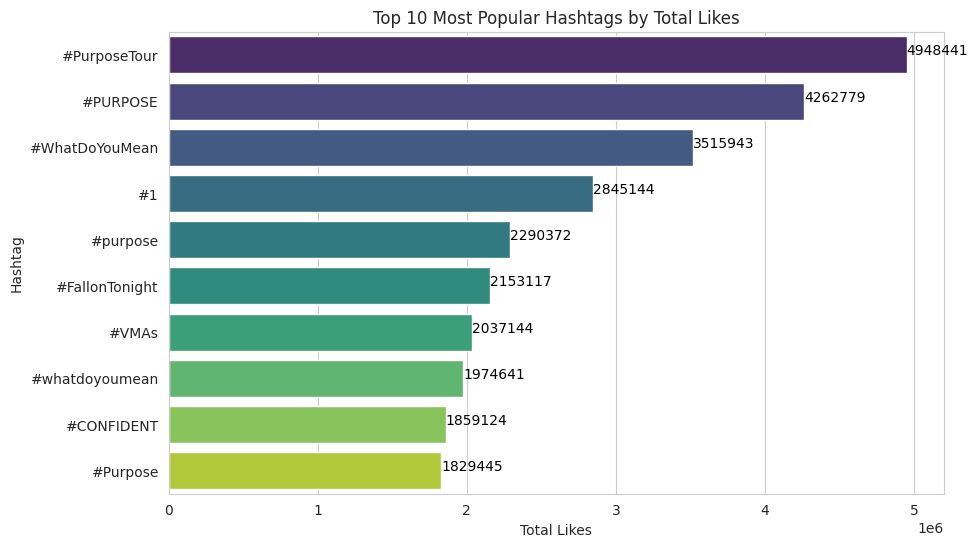

In [101]:
# Query 1 - Most Popular Hashtags by Year
rows = session.execute(queries["Most Popular Hashtags by Year"])
df = pd.DataFrame(list(rows))
result = df.groupby('tag_name').agg(
total_likes=pd.NamedAgg(column='number_of_likes', aggfunc='sum'),
).sort_values(by='total_likes', ascending=False).head(10)

# Create a figure and a set of subplots
plt.figure(figsize=(10, 6))

# Bar plot for total_likes
barplot = sns.barplot(x='total_likes', y='tag_name', data=result.reset_index(), palette='viridis')

# Add chart labels and title
plt.xlabel('Total Likes')
plt.ylabel('Hashtag')
plt.title('Top 10 Most Popular Hashtags by Total Likes')

for index, row in result.iterrows():
    barplot.text(row.total_likes, index, round(row.total_likes), color='black', ha="left")

# Show plot
plt.show()    


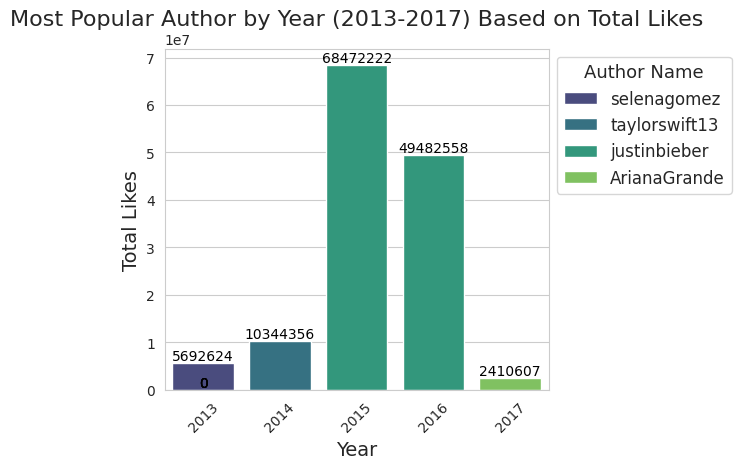

In [100]:
#Query 2 - Most Popular Author by Year
rows = session.execute(queries["Most Popular Author by Year"])
df = pd.DataFrame(list(rows))

# Ensure 'date_time' is a datetime type
df['date_time'] = pd.to_datetime(df['date_time'])

# Extract the year from 'date_time'
df['year'] = df['date_time'].dt.year

# Filter the DataFrame for years 2013 to 2017
filtered_df = df[(df['year'] >= 2013) & (df['year'] <= 2017)]

#Group by 'year' and 'author_name', then sum 'number_of_likes' and 'number_of_shares'
aggregated_df = filtered_df.groupby(['year', 'author_name']).agg(
    total_likes=pd.NamedAgg(column='number_of_likes', aggfunc='sum'),
    total_shares=pd.NamedAgg(column='number_of_shares', aggfunc='sum')
).reset_index()

# For each year, find the author with the highest total likes
most_popular_author_by_year = aggregated_df.loc[aggregated_df.groupby('year')['total_likes'].idxmax()]

barplot = sns.barplot(
    x='year',
    y='total_likes',
    hue='author_name',
    data=most_popular_author_by_year,
    dodge=False,
    palette='viridis'
)

# Add title and labels
plt.title('Most Popular Author by Year (2013-2017) Based on Total Likes', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Likes', fontsize=14)

# Place the legend outside the plot
plt.legend(title='Author Name', title_fontsize='13', fontsize='12', bbox_to_anchor=(1, 1), loc='upper left')

# Show values on top of the bars
for bar in barplot.patches:
    # The text annotation for each bar
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             round(bar.get_height()),
             ha='center', va='bottom', color='black')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Adjust the plot layout to fit everything
plt.tight_layout()

In [102]:
#Query 3 - Correlation between Hashtag and Likes/Shares
rows = session.execute(queries["Correlation between Hashtag and Likes/Shares"])
df = pd.DataFrame(list(rows))

# Our data contains multipale entries for the same tag, we will sum up the number of like and shares
# Aggregate likes and shares by summing them up
aggregated_data = df.groupby('tag_name').sum().reset_index()

if not aggregated_data.empty:
    correlation = aggregated_data['number_of_likes'].iloc[0] / aggregated_data['number_of_shares'].iloc[0]
    print(f"The correlation coefficient between number_of_likes and number_of_shares for #TheUncommonThread is: {correlation}")
else:
    print("No data available to calculate correlation.")

The correlation coefficient between number_of_likes and number_of_shares for #TheUncommonThread is: 2.130969671080735


In [113]:
#Query 4 - Correlation between Likes and Shares Globally
rows = session.execute(queries["Correlation between Likes and Shares Globally"])
df = pd.DataFrame(list(rows))
correlation = df['total_likes'][0] / df['total_shares'][0]

print(f"The correlation coefficient between number_of_likes and number_of_shares globally is: {correlation}")

The correlation coefficient between number_of_likes and number_of_shares globally is: 1.6758907772683747


In [194]:
#Query 5 - Emoji Histogram
rows = session.execute(queries["Emoji Histogram"])
df = pd.DataFrame(list(rows))

# Count the appearances of each emoji
emoji_counts = df['emoji'].value_counts()

# Convert the Series back into a DataFrame for easier handling
emoji_counts_df = emoji_counts.reset_index()
emoji_counts_df.columns = ['Emoji', 'Count']

# Select the top 10 emojis
top_emojis_df = emoji_counts_df.head(10)

print("Top 10 emojis based on their appearance count:")
print(top_emojis_df)

Top 10 emojis based on their appearance count:
  Emoji  Count
0     🏼    365
1     🙏    292
2     💜    256
3     😍    241
4     🐾    225
5     💗    220
6     💋    212
7     😂    197
8     😘    184
9     🙌    166


In [197]:
#Query 6 - Most Used Emoji Given Author
rows = session.execute(queries["Most Used Emojis for Given Author"])
df = pd.DataFrame(list(rows))

# Sort the DataFrame based on the 'total_interactions' column in descending order
df_sorted = df.sort_values(by='total_interactions', ascending=False)

# Select the top 10 rows
top_10_df = df_sorted.head(10)

print("Top 10 emojis used by Katy Perry based on total_interactions are:")

# Print the top 10 rows
print(top_10_df)

Top 10 emojis used by Katy Perry are:
    emoji     author  total_interactions
163     🏼  katyperry             1465837
180     💅  katyperry              851393
228     🙏  katyperry              772808
183     🏻  katyperry              659090
214     😩  katyperry              589071
146     💁  katyperry              586518
182     🙌  katyperry              568512
40      😳  katyperry              495342
134     🔥  katyperry              484572
95      👀  katyperry              482220


This pie chart shows the distribution of days based on the number of unique users observed each day.


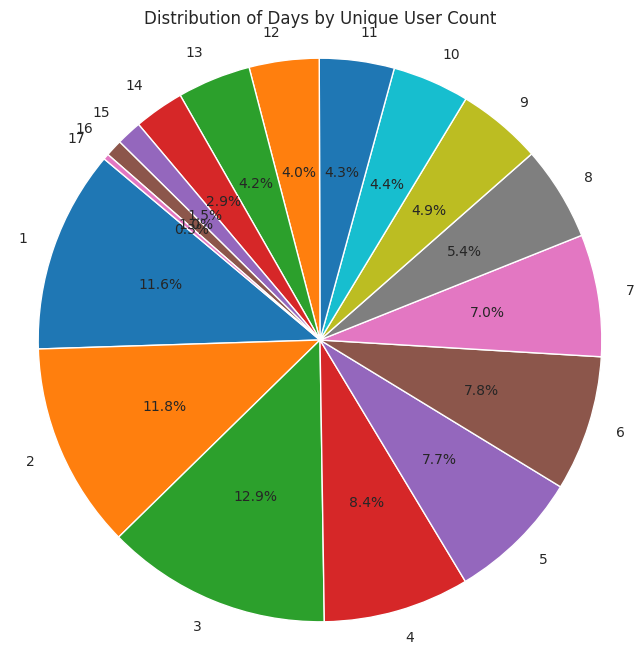

In [230]:
# Query 7 - Daily Active Users
print("This pie chart shows the distribution of days based on the number of unique users observed each day.")
rows = session.execute(queries["Daily Active Users"])
df = pd.DataFrame(list(rows))

# Convert 'date_time' to datetime object
df['date_time'] = pd.to_datetime(df['date_time'])

# Extract date from datetime
df['date'] = df['date_time'].dt.date

# Count the unique users for each day
daily_unique_users = df.groupby('date')['author_name'].nunique().reset_index()
daily_unique_users.columns = ['date', 'unique_users']

# Group together the days with the same number of unique users
grouped_unique_users = daily_unique_users.groupby('unique_users')['date'].count().reset_index()
grouped_unique_users.columns = ['unique_users', 'days_count']

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(grouped_unique_users['days_count'], labels=grouped_unique_users['unique_users'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Days by Unique User Count')
plt.axis('equal')
plt.show()